## WfCommons to QUBO: Dealing with inequality constraints 

An inequality constraint:  $$h(x) = \sum_{i} l_i x_i  - C \leq 0$$

1) Using slacks: 

$$ \big(\sum_{i} l_i x_i + \sum_{k} 2^k s_k - C \big)^2 = 0  $$


2. Using the **unbalanced function** (A. Montanez-Barrera et al., 2022) :

$$ e^{h(x)} \approx 1 + h(x) + \frac{1}{2} h(x)^2 $$

$$ \lambda_1 \big(\sum_{i} l_i x_i - C\big) + \lambda_2 \big(\sum_{i} l_i x_i - C\big)^2 $$

2. Using the **unbalanced function** (A. Montanez-Barrera et al., 2022) :

$$ e^{h(x)} \approx 1 + h(x) + \frac{1}{2} h(x)^2 $$

$$ \lambda_1 \big(\sum_{i} l_i x_i - C\big) + \lambda_2 \big(\sum_{i} l_i x_i - C\big)^2 $$

In [1]:
import numpy as np
params_config = {
    'angles': [[1.9482, 4.2254, 4.1086, 5.7801, 4.1416, 3.8738],   # gammas
               [0.9043, 2.5178, 1.7931, 2.4655, 1.3755, 1.0457]],  # betas
    'hyper_args': [1, 2, 2], # obj. function, lambda_1, lambda_2
}

In [2]:
from QHyper.solvers import VQA, solver_from_config

solver_config = {
    "problem": {
        "type": "workflow_scheduling",
        "encoding": "binary",
        "tasks_file": "workflows_data/workflows/3_tasks_1_path.json",
        "machines_file": "workflows_data/machines/4_machines.json",
        "deadline": 13,
    },
    "solver": {
        "type": "vqa",
        "pqc": {
            "type": "sim_hamiltonian_qaoa",
            "layers": 6,
            "optimizer": "adam",
            "optimizer_args": {
                "stepsize": 0.00045,
                "steps": 1,
                "verbose": True,
            },
            "backend": "lightning.qubit",
        },
        "params_inits": params_config
    }
}

vqa = solver_from_config(solver_config)

In [13]:
vqa.problem.constraints

[{('x0', 'x1'): 16.0, ('x0',): -2.0, ('x1',): -4.0, ('x2', 'x3'): 8.0, ('x2',): -1.0, ('x3',): -2.0, ('x4', 'x5'): 32.0, ('x4',): -4.0, ('x5',): -8.0, (): 21.0} <= 13]

In [3]:
import pennylane as qml

dev = qml.device("lightning.qubit", wires=[str(x) for x in vqa.problem.variables] + [f"a{i}" for i in range(3 + 2 + len(vqa.problem.variables))])

vqa.pqc.dev = dev
test_circuit = vqa.pqc.get_expval_circuit(vqa.problem, list(vqa.params_inits['hyper_args']))

# cost_operator = vqa.pqc.create_qubo(vqa.problem, list(vqa.params_inits['hyper_args']))
# @qml.qnode(dev)
# def test_circuit(params):
#     vqa.pqc._circuit(vqa.problem, params, cost_operator)
#     return qml.state()

In [4]:
print(test_circuit(vqa.params_inits['angles']))

SimHamiltonianQAOA 6 lightning.qubit
25.102057580503878


In [30]:
import math
from QHyper.util import Operator
import pennylane as qml

def ctrl_add(k):
    def func(r_qbits, control_qbits):
        for i in range(len(r_qbits)):
            qml.ctrl(qml.RZ, control=control_qbits, control_values=[1]*len(control_qbits))(k * np.pi / (2**i), wires=r_qbits[i])
    return func

def add(k):
    def func(r_qbits):
        for i in range(len(r_qbits)):
            qml.RZ(k * np.pi / (2**i), wires=r_qbits[i])
    return func
        
def check_constraint(constraint, C):
    def func(r_qbits, control_qbits):
        qml.QFT(wires=r_qbits)
        for vars, coeff in constraint.lhs.items():
            if len(vars) == 0:
                continue
                    
            ctrl_add(coeff)(r_qbits, [control_qbits[int(str(x)[1])] for x in vars])
        add(C)(r_qbits)
        qml.adjoint(qml.QFT)(wires=r_qbits)
    return func
        
def check_constraints(y_qbits, c_flag_qbits, ancilla_qbits):
    for constraint,flag_qbit in zip(vqa.problem.constraints, c_flag_qbits):
        max_v = sum([coeff if coeff > 0 and len(vars) > 0 else 0 for vars, coeff in constraint.lhs.items()])
        min_v = sum([coeff if coeff < 0 and len(vars) > 0 else 0 for vars, coeff in constraint.lhs.items()])
        C = sum([coeff if len(vars) == 0 else 0 for vars, coeff in constraint.lhs.items()]) - constraint.rhs
        if constraint.operator == Operator.GE:
            max_v, min_v = -min_v, -max_v
            C = -C

        min_v -= 1
        if C > 0:
            vrange = (min_v, max_v + C)
        else:
            vrange = (min_v + C, max_v)

        if vrange[1] <= 0 or vrange[0] >= 0:
            print("Constraint is always satisfied")
            continue

        neg_len = math.ceil(math.log2(-vrange[0]))
        pos_len = math.ceil(math.log2(vrange[1] + 1))
        r_len = max(neg_len, pos_len) + 1
        r_qbits = ancilla_qbits[:r_len]

        check_constraint(constraint, C-1)(r_qbits, y_qbits)
        qml.ctrl(qml.PauliX, control=r_qbits[0], control_values=1)(flag_qbit)
        qml.adjoint(check_constraint(constraint, C-1))(r_qbits, y_qbits)
        
def validate(y_qbits, flag_qbit, ancilla_qbits) -> None:
    c_flag_qbits = ancilla_qbits[:len(vqa.problem.constraints)]
    ancilla_qbits = ancilla_qbits[len(vqa.problem.constraints):]

    check_constraints(y_qbits, c_flag_qbits, ancilla_qbits)
    qml.ctrl(qml.PauliX, control=c_flag_qbits, control_values=[1]*len(c_flag_qbits))(flag_qbit)
    qml.adjoint(check_constraints)(y_qbits, c_flag_qbits, ancilla_qbits)

dev = qml.device("lightning.qubit", wires=[str(x) for x in vqa.problem.variables] + [f"a{i}" for i in range(10)])

@qml.qnode(dev)
def test_validate():
    for x in vqa.problem.variables:
        qml.Hadamard(wires=str(x))
    validate([str(x) for x in vqa.problem.variables], "a0", [f"a{i}" for i in range(1, 10)])
    return qml.probs(wires=[str(x) for x in vqa.problem.variables] + ["a0"])

probs = test_validate()
probs = {
    format(result, "b").zfill(len(vqa.problem.variables)+1): float(prob)
    for result, prob in enumerate(probs)
}

for k,v in probs.items():
    if k[6] == "1" and abs(v) > 1e-15:
        print(k[:6], v)

000001 0.015625000000060528
000101 0.01562500000006007
001001 0.0156250000000603
010001 0.01562500000005959
010010 0.015625000000060528
010101 0.015625000000059112
010110 0.01562500000006007
011001 0.015625000000059355
011010 0.015625000000060306
100001 0.01562500000006007
100101 0.015625000000059612
100110 0.01562500000006055
101001 0.015625000000059827


In [ ]:
from QHyper.util import Operator

variables_n = len(vqa.problem.variables)
#x = 0b100000
for ox in range(2**variables_n):
    x = list(map(int, bin(ox)[2:].zfill(variables_n)))[::-1]
    values = {str(var): x[i] for i,var in enumerate(vqa.problem.variables)}

    valid = True
    for constraint in vqa.problem.constraints:
        res = 0
        for vars, coeff in constraint.lhs.items():
            res += coeff * np.prod([values[var] for var in vars])

        if constraint.operator == Operator.LE:
            valid = res <= constraint.rhs
        elif constraint.operator == Operator.GE:
            valid = res >= constraint.rhs
        
        if not valid:
            break
    
    if not valid:
        continue

    res = -8*values['x0']*values['x1'] + 2*values['x0'] + 2*values['x1'] - 4*values['x2']*values['x3'] + values['x2'] + values['x3'] - 16*values['x4']*values['x5'] + 4*values['x4'] + 4*values['x5'] + 21
    print(bin(ox)[2:].zfill(variables_n), res)

#vqa.problem.objective_function.as_polynomial()

# for constraint in vqa.problem.constraints:
#     res = 0
#     for vars, coeff in constraint.lhs.items():
#         res += coeff * np.prod([values[var] for var in vars])

#     if constraint.operator == Operator.LE:
#         print(res, "<=", constraint.rhs, ":", res <= constraint.rhs)
#     elif constraint.operator == Operator.GE:
#         print(res, ">=", constraint.rhs, ":", res >= constraint.rhs)

010010 27
010110 28
011001 28
011010 28
100000 25
100001 27
100010 27
100100 26
100101 28
100110 28
101000 26
101001 28
101010 28


In [ ]:
import pennylane as qml
import pennylane.numpy as np

qml.grad(vqa.pqc.get_expval_circuit(vqa.problem, params_config['hyper_args']))(np.array(params_config['angles']))

In [ ]:
vqa.pqc.get_expval_circuit(vqa.problem, params_config['hyper_args'])(np.array(params_config['angles']))

In [ ]:
opt = qml.AdamOptimizer()
theta_new = opt.step(vqa.pqc.get_expval_circuit(vqa.problem, params_config['hyper_args']), np.array(params_config['angles']))
theta_new

In [4]:
solver_results = vqa.solve()

SimHamiltonianQAOA 6 lightning.qubit
Step 1/1: 27.463085002458072
SimHamiltonianQAOA 6 lightning.qubit


<Axes: xlabel='index', ylabel='value'>

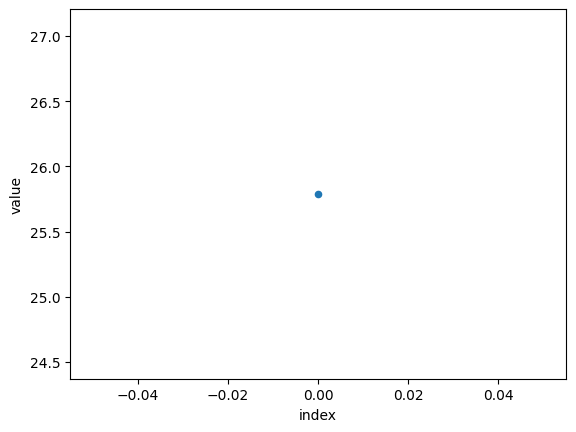

In [ ]:
import pandas as pd

pd.DataFrame(solver_results.history[0]).reset_index().plot(x='index',y='value', kind='scatter')

In [11]:
print(f"Best params: {solver_results.params}")

Best params: {'angles': tensor([[1.9482    , 4.22540002, 4.10860029, 5.7800999 , 4.1415997 ,
         3.87379895],
        [0.9043    , 2.5178    , 1.7931    , 2.4655    , 1.3755    ,
         1.0457    ]], requires_grad=True), 'hyper_args': tensor([1, 2, 2], requires_grad=True)}


In [5]:
from QHyper.util import (
    weighted_avg_evaluation, sort_solver_results, add_evaluation_to_results)

# Evaluate results with weighted average evaluation
print("Evaluation:")
print(weighted_avg_evaluation(
    solver_results.results_probabilities, vqa.problem.get_score,
    penalty=0, limit_results=20, normalize=True
))
print("Sort results:")
sorted_results = sort_solver_results(
    solver_results.results_probabilities, limit_results=20)

# Add evaluation to results
results_with_evaluation = add_evaluation_to_results(
    sorted_results, vqa.problem.get_score, penalty=0)

for result, (probability, evaluation) in results_with_evaluation.items():
    print(f"Result: {result}, "
          f"\t Prob: {probability:.5}, "
          f"\t Evaluation: {evaluation}")

Evaluation:
27.4593237156662
Sort results:
Result: 011001, 	 Prob: 0.24991, 	 Evaluation: 28.0
Result: 011010, 	 Prob: 0.14619, 	 Evaluation: 28.0
Result: 001001, 	 Prob: 0.11641, 	 Evaluation: 26.0
Result: 100110, 	 Prob: 0.076923, 	 Evaluation: 28.0
Result: 010001, 	 Prob: 0.073999, 	 Evaluation: 27.0
Result: 101001, 	 Prob: 0.072245, 	 Evaluation: 28.0
Result: 010101, 	 Prob: 0.070593, 	 Evaluation: 28.0
Result: 010010, 	 Prob: 0.043287, 	 Evaluation: 27.0
Result: 010110, 	 Prob: 0.041294, 	 Evaluation: 28.0
Result: 000001, 	 Prob: 0.03447, 	 Evaluation: 25.0
Result: 000101, 	 Prob: 0.032883, 	 Evaluation: 26.0
Result: 100001, 	 Prob: 0.021392, 	 Evaluation: 27.0
Result: 100101, 	 Prob: 0.020407, 	 Evaluation: 28.0
Result: 000110, 	 Prob: 4.4658e-13, 	 Evaluation: 0
Result: 110101, 	 Prob: 3.9316e-13, 	 Evaluation: 0
Result: 110001, 	 Prob: 3.1987e-13, 	 Evaluation: 0
Result: 100111, 	 Prob: 2.7091e-13, 	 Evaluation: 0
Result: 000010, 	 Prob: 2.5406e-13, 	 Evaluation: 0
Result: 0010

3_tasks_1_path
100 steps


Step 1/100: 25.968905774803304
Step 2/100: 25.96247836802759
Step 3/100: 25.956240732858326
Step 4/100: 25.950199566933627
Step 5/100: 25.944360737418947
Step 6/100: 25.938728969308432
Step 7/100: 25.93330744625486
Step 8/100: 25.9280973176079
Step 9/100: 25.923097132379045
Step 10/100: 25.9183022750492
Step 11/100: 25.91370455419189
Step 12/100: 25.909292150526607
Step 13/100: 25.90505009368018
Step 14/100: 25.90096127716746
Step 15/100: 25.89700781546321
Step 16/100: 25.893172414662633
Step 17/100: 25.88943943504043
Step 18/100: 25.88579546486404
Step 19/100: 25.882229421076893
Step 20/100: 25.87873232932199
Step 21/100: 25.87529696019702
Step 22/100: 25.8719174476026
Step 23/100: 25.868588951516337
Step 24/100: 25.86530738485753
Step 25/100: 25.86206920379774
...
Step 97/100: 25.65343702502367
Step 98/100: 25.650518023342087
Step 99/100: 25.647601797128527
Step 100/100: 25.644688867254033



Evaluation:
25.641779768292206
Sort results:
Result: 000001, 	 Prob: 0.40823, 	 Evaluation: 25.0
Result: 001001, 	 Prob: 0.28299, 	 Evaluation: 26.0
Result: 000101, 	 Prob: 0.28299, 	 Evaluation: 26.0
Result: 010101, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 010110, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 011001, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 011010, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 100101, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 100110, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 101001, 	 Prob: 0.0034585, 	 Evaluation: 28.0
Result: 010001, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 010010, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 100001, 	 Prob: 0.00052923, 	 Evaluation: 27.0
Result: 000110, 	 Prob: 4.5386e-31, 	 Evaluation: 0
Result: 000010, 	 Prob: 4.0017e-31, 	 Evaluation: 0
Result: 001011, 	 Prob: 2.4083e-31, 	 Evaluation: 0
Result: 000100, 	 Prob: 1.9277e-31, 	 Evaluation: 0
Result: 001101, 	 Prob: 1.798e-31, 	 Evaluation: 0
Result: 001010, 	 Prob: 8.3883e-32, 	 Evaluation: 0
Result: 001100, 	 Prob: 7.2327e-32, 	 Evaluation: 0

In [ ]:
solver_config = {
    "problem": {
        "type": "workflow_scheduling",
        "encoding": "one-hot",
        "tasks_file": "workflows_data/workflows/srasearch_22_tasks.json", 
        "machines_file": "workflows_data/machines/cyfronet.json",
        "deadline": 5000,
    },
    "solver": {
        "type": "cqm",
        "time": 10,
    }
}

cqm = solver_from_config(solver_config)

In [ ]:
result = cqm.solve()

In [ ]:
cqm.problem.decode_solution(result)

{'bowtie2-build_ID0000001': 'AresCpu',
 'bowtie2_ID0000021': 'AresGpu',
 'merge_ID0000022': 'ZeusCpu',
 'bowtie2_ID0000003': 'AresGpu',
 'fasterq-dump_ID0000004': 'AresGpu',
 'bowtie2_ID0000005': 'PrometeusGpu',
 'fasterq-dump_ID0000006': 'AresGpu',
 'bowtie2_ID0000007': 'PrometeusGpu',
 'fasterq-dump_ID0000008': 'AresGpu',
 'bowtie2_ID0000009': 'PrometeusGpu',
 'fasterq-dump_ID0000010': 'AresGpu',
 'bowtie2_ID0000011': 'PrometeusGpu',
 'fasterq-dump_ID0000012': 'AresGpu',
 'fasterq-dump_ID0000002': 'AresGpu',
 'bowtie2_ID0000013': 'PrometeusGpu',
 'fasterq-dump_ID0000014': 'AresGpu',
 'bowtie2_ID0000015': 'PrometeusGpu',
 'fasterq-dump_ID0000016': 'AresGpu',
 'bowtie2_ID0000017': 'AresGpu',
 'fasterq-dump_ID0000018': 'AresGpu',
 'bowtie2_ID0000019': 'PrometeusGpu',
 'fasterq-dump_ID0000020': 'AresGpu'}